In [318]:
# Import libraries
import os
import re
import nltk
import pickle
import urllib
import string
import sqlite3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
from bs4 import BeautifulSoup
from argparse import Namespace
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer
from gensim.models import KeyedVectors
from sklearn.metrics import roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
warnings.filterwarnings("ignore")

color = sns.color_palette()

In [319]:
# Read train data
df = pd.read_csv('address_matching_data.csv', na_values='?')
print("Number of data points:",df.shape)

Number of data points: (28235, 31)


In [320]:
# Read test data
df_test = pd.read_csv('address_matching_test.csv', na_values='?')
print("Number of data points:",df_test.shape)

Number of data points: (6230, 30)


In [321]:
df.sample(5)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
1016,6143#6200,0.666667,0.600000,0.658537,0.460000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,m,m,n,1
13348,1105#1112,0.800000,0.800000,0.571429,0.600000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,m,m,n,1
162,3730#3735,0.455357,0.163889,0.384615,0.157895,1.0,1.0,1.0,1.0,0.8,...,NaN,NaN,NaN,NaN,0.6,0.222222,m,m,n,-1
16579,2690#2692,1.000000,1.000000,0.090909,1.000000,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,1.000000,s,m,s,1
19615,1329#1333,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.000000,m,m,s,1


In [322]:
df_test.sample(5)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,website_trigram_term,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality
863,12054#12055,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,1.000000,1.000000,s,m,s
326,3691#3695,0.119048,0.000000,0.142857,0.000000,1.0,1.0,1.0,1.0,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,m,m,n
1220,6775#6776,1.000000,1.000000,0.125000,1.000000,1.0,1.0,1.0,1.0,NaN,...,NaN,1.0,1.0,NaN,NaN,0.428571,0.200000,s,m,n
5686,1762#1772,0.500000,0.400000,0.368421,0.178571,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.500000,0.250000,m,m,n
483,3654#3656,0.172619,0.025641,0.173913,0.027778,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.500000,0.285714,m,m,n


In [323]:
# find duplicate data
df[df.duplicated(subset='id')].shape

(414, 31)

In [324]:
df[df.id == '12258#12259']

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
22490,12258#12259,0.188571,0.000000,0.157895,0.000000,NaN,NaN,NaN,NaN,NaN,...,0.400000,0.222222,NaN,NaN,NaN,NaN,n,m,n,-1
27520,12258#12259,0.590909,0.563636,0.543478,0.489362,1.0,1.0,1.0,1.0,1.0,...,0.545455,0.200000,NaN,NaN,0.8,0.5,n,m,n,-1


In [325]:
# drop duplicate data
df.drop_duplicates(subset='id', keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)


(27821, 31)


In [326]:
df.head(10)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
0,1204#1207,0.666667,0.666667,0.400000,0.526316,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.000000,m,m,s,1
1,1272#1279,0.666667,0.666667,0.411765,0.444444,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.000000,m,m,s,1
2,6258#6259,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,1.000000,s,m,s,1
3,16076#16077,0.565476,0.333333,0.260870,0.189189,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,0.0,0.000000,s,m,n,-1
4,2666#2671,0.666667,0.666667,0.500000,0.518519,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,1.000000,s,m,s,1
5,4402#4403,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,1.000000,s,m,s,1
6,4025#4028,0.121032,0.000000,0.185185,0.000000,1.0,1.0,1.0,1.0,0.8,...,NaN,NaN,NaN,NaN,0.5,0.250000,m,m,n,-1
7,4126#4138,0.355556,0.250000,0.333333,0.159091,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.6,0.222222,m,m,n,-1
8,4559#4560,0.167298,0.000000,0.173913,0.000000,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,m,m,n,-1
9,15610#15611,0.208333,0.000000,0.266667,0.000000,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,m,m,n,-1


In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27821 entries, 0 to 27820
Data columns (total 31 columns):
id                            27821 non-null object
name_levenshtein_simple       27821 non-null float64
name_trigram_simple           27821 non-null float64
name_levenshtein_term         27821 non-null float64
name_trigram_term             27821 non-null float64
city_levenshtein_simple       9834 non-null float64
city_trigram_simple           9834 non-null float64
city_levenshtein_term         9834 non-null float64
city_trigram_term             9834 non-null float64
zip_levenshtein_simple        7607 non-null float64
zip_trigram_simple            7607 non-null float64
zip_levenshtein_term          7607 non-null float64
zip_trigram_term              7607 non-null float64
street_levenshtein_simple     8150 non-null float64
street_trigram_simple         8150 non-null float64
street_levenshtein_term       8150 non-null float64
street_trigram_term           8150 non-null float64
web

In [328]:
df.describe()

,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,zip_trigram_simple,...,website_trigram_simple,website_levenshtein_term,website_trigram_term,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,is_match
count,27821.000000,27821.000000,27821.000000,27821.000000,9834.000000,9834.000000,9834.000000,9834.000000,7607.000000,7607.000000,...,1807.000000,1807.000000,1807.000000,11614.000000,11614.000000,689.000000,689.000000,18162.000000,18162.000000,27821.000000
mean,0.630484,0.566405,0.538959,0.512527,0.882605,0.853599,0.867607,0.853920,0.893279,0.836168,...,0.786666,0.760340,0.713917,0.848102,0.773858,0.765616,0.654163,0.891767,0.834088,0.450415
std,0.304539,0.368499,0.324915,0.372035,0.250899,0.303910,0.275152,0.306377,0.248651,0.321806,...,0.260502,0.285611,0.333915,0.250323,0.341036,0.280800,0.384489,0.216502,0.308442,0.892835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.028219,0.061856,0.025316,0.100000,0.000000,0.100000,0.047619,0.000000,0.000000,-1.000000
25%,0.368056,0.233333,0.250000,0.150000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.564103,0.484611,0.352146,0.727273,0.437500,0.500000,0.263158,1.000000,1.000000,-1.000000
50%,0.666667,0.666667,0.478261,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.966667,0.978495,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


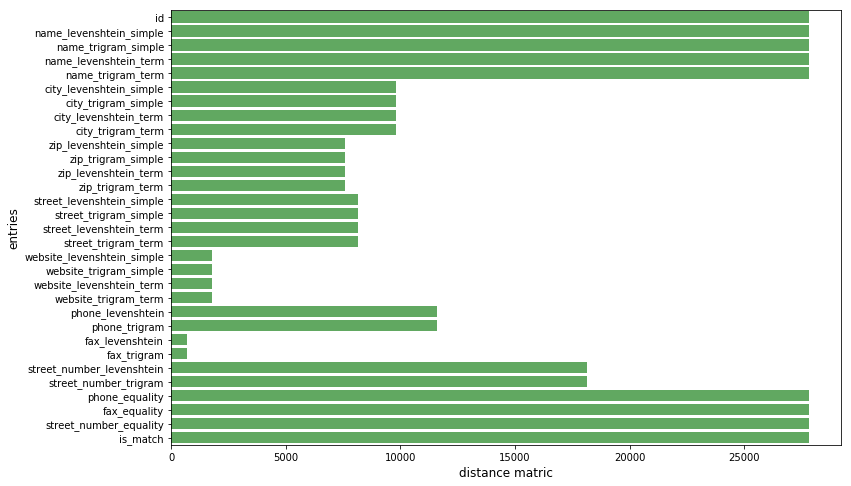

In [329]:
# check number of non null values in each column
not_null = pd.DataFrame(columns=['column', 'count'])
column = df.columns
for index, col in enumerate(list(column)):
    not_null.loc[index] = {'column':col, 'count': df[col].count()}

plt.figure(figsize=(12,8))
sns.barplot(not_null['count'], not_null['column'], alpha=0.8, color=color[2])
plt.xlabel('distance matric', fontsize=12)
plt.ylabel('entries', fontsize=12)
plt.show()


In [330]:
df.sample(4)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
26522,9004#9005,0.466667,0.400000,0.157895,0.304348,1.0,1.000000,1.0,1.000000,NaN,...,1.000000,1.0,NaN,NaN,1.0,1.0,s,m,s,1
27423,8978#9004,0.466667,0.400000,0.263158,0.304348,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,NaN,NaN,1.0,1.0,s,m,s,1
7391,2208#2221,0.428571,0.333333,0.344828,0.250000,NaN,NaN,NaN,NaN,NaN,...,0.363636,0.2,0.909091,0.714286,1.0,1.0,n,n,s,1
12511,915#917,1.000000,1.000000,0.250000,1.000000,0.3,0.058824,0.3,0.058824,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,m,m,s,1


In [331]:
# There are catagorial data columns in train data
# use lable encoding and one hot encoding to make it numerical value
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df.iloc[:, df.columns.get_loc('phone_equality')] = labelencoder.fit_transform(df.iloc[:, df.columns.get_loc('phone_equality')]).reshape(df.shape[0], 1)
df.iloc[:, df.columns.get_loc('fax_equality')] = labelencoder.fit_transform(df.iloc[:, df.columns.get_loc('fax_equality')])
df.iloc[:, df.columns.get_loc('street_number_equality')] = labelencoder.fit_transform(df.iloc[:, df.columns.get_loc('street_number_equality')])

df.head(5)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
0,1204#1207,0.666667,0.666667,0.400000,0.526316,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,0,0,2,1
1,1272#1279,0.666667,0.666667,0.411765,0.444444,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,0,0,2,1
2,6258#6259,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,1.0,2,0,2,1
3,16076#16077,0.565476,0.333333,0.260870,0.189189,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,0.0,0.0,2,0,1,-1
4,2666#2671,0.666667,0.666667,0.500000,0.518519,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,1.0,2,0,2,1


In [332]:
# There are catagorial data columns in test data
# use lable encoding and one hot encoding to make it numerical value
labelencoder_test = LabelEncoder()

df_test.iloc[:, df_test.columns.get_loc('phone_equality')] = labelencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('phone_equality')]).reshape(df_test.shape[0], 1)
df_test.iloc[:, df_test.columns.get_loc('fax_equality')] = labelencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('fax_equality')])
df_test.iloc[:, df_test.columns.get_loc('street_number_equality')] = labelencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('street_number_equality')])

df_test.head(5)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,website_trigram_term,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality
0,7221#7218,0.703704,0.666667,0.680000,0.533333,1.000000,1.000000,1.000000,1.0,1.0,...,NaN,1.0,1.0,NaN,NaN,1.0,1.0,2,0,2
1,2393#2398,1.000000,1.000000,0.520000,1.000000,0.666667,0.666667,0.454545,0.5,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0,2
2,2509#2510,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,2,0,1
3,3695#3700,0.111310,0.000000,0.095238,0.000000,1.000000,1.000000,1.000000,1.0,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
4,15918#15955,0.175000,0.074074,0.153846,0.095238,1.000000,1.000000,1.000000,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1


In [333]:
# one hot encoding for train

from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(sparse=False)

print(df.shape)

temp1 = onehotencoder.fit_transform(df.iloc[:, df.columns.get_loc('phone_equality')].reshape(-1, 1))
ohe1 = pd.DataFrame(temp1, columns=['sne_s1','sne_m1','sne_n1'])

print(ohe1.shape)

temp2 = onehotencoder.fit_transform(df.iloc[:, df.columns.get_loc('fax_equality')].reshape(-1, 1))
ohe2 = pd.DataFrame(temp2, columns=['sne_s2','sne_m2','sne_n2'])
print(ohe2.shape)
temp3 = onehotencoder.fit_transform(df.iloc[:, df.columns.get_loc('street_number_equality')].reshape(-1, 1))
ohe3 = pd.DataFrame(temp3, columns=['sne_s3','sne_m3','sne_n3'])
print(ohe3.shape)
df1 = pd.concat([df, ohe1, ohe2, ohe3], axis=1)
print(df1.shape)
# df1.sample(5)


(27821, 31)
(27821, 3)
(27821, 3)
(27821, 3)
(27821, 40)


In [334]:
# one hot encoding for test

onehotencoder_test = OneHotEncoder(sparse=False)

temp1 = onehotencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('phone_equality')].reshape(-1, 1))
ohe1 = pd.DataFrame(temp1, columns=['sne_s1','sne_m1','sne_n1'])

print(ohe1.shape)

temp2 = onehotencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('fax_equality')].reshape(-1, 1))
ohe2 = pd.DataFrame(temp2, columns=['sne_s2','sne_m2','sne_n2'])
print(ohe2.shape)
temp3 = onehotencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('street_number_equality')].reshape(-1, 1))
ohe3 = pd.DataFrame(temp3, columns=['sne_s3','sne_m3','sne_n3'])
print(ohe3.shape)
df_test1 = pd.concat([df_test, ohe1, ohe2, ohe3], axis=1)
print(df_test1.shape)

(6230, 3)
(6230, 3)
(6230, 3)
(6230, 39)


In [335]:
# drop columns from train data

df1 = df1.drop(['id','phone_equality','fax_equality','street_number_equality'], axis=1)
df1.sample(5)

,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,zip_trigram_simple,...,is_match,sne_s1,sne_m1,sne_n1,sne_s2,sne_m2,sne_n2,sne_s3,sne_m3,sne_n3
10393,0.285185,0.242424,0.288889,0.255319,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2409,0.800000,0.800000,0.684211,0.684211,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1605,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
13580,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
11848,0.857143,0.857143,0.785714,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [336]:
# drop columns from test data

df_test_id = df_test1.id
df_test1 = df_test1.drop(['id','phone_equality','fax_equality','street_number_equality'], axis=1)
df_test1.shape

(6230, 35)

In [337]:
# check class embalance

for i, j in df.groupby('is_match'):
    print(i, j.is_match.count())

-1 7645
1 20176


In [338]:
# replace na value of each column with mean of that column in train data

df2 = df1.copy()
column = df2.select_dtypes(include=[np.number]).columns.tolist()
for col in column:
    df2.loc[df2[col].isna(), col] = df2.loc[df2[col].notna(), col].mean()

df2.shape

(27821, 36)

In [339]:
# replace na value of each colun with mean of that column in test data

df_test2 = df_test1.copy()
column = df_test2.select_dtypes(include=[np.number]).columns.tolist()
for col in column:
    df_test2.loc[df_test2[col].isna(), col] = df_test2.loc[df_test2[col].notna(), col].mean()

# df3 = df2.fillna(0.5)
df_test2.shape

(6230, 35)

In [340]:
df_test2.sample(4)

,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,zip_trigram_simple,...,street_number_trigram,sne_s1,sne_m1,sne_n1,sne_s2,sne_m2,sne_n2,sne_s3,sne_m3,sne_n3
4965,1.000000,1.000000,1.000000,1.000000,0.887698,0.857783,0.878316,0.859965,0.887348,0.820223,...,0.827768,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5411,0.448822,0.357143,0.257143,0.236842,0.887698,0.857783,0.878316,0.859965,0.887348,0.820223,...,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
755,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.887348,0.820223,...,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3557,0.800000,0.800000,0.666667,0.684211,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


-1.0 7645
1.0 20176


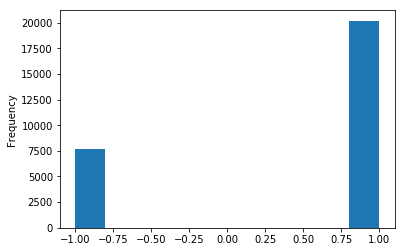

In [341]:
df2.is_match.plot.hist()
for i, j in df2.groupby('is_match'):
    print(i, j.is_match.count())

In [342]:
# deal with unbalanced data with upsampling technique

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df2[df2.is_match==1]
df_minority = df2[df2.is_match==-1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df3 = pd.concat([df_majority, df_minority_upsampled])
df3.is_match.value_counts()

-1.0    20176
 1.0    20176
Name: is_match, dtype: int64

In [343]:
# Train test data seperation

X = df3.drop(['is_match'], axis=1)
y = df3['is_match']

print(X.shape)
print(y.shape)

(40352, 35)
(40352,)


In [344]:
# train test spliting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) # this is random splitting
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(28246, 35) (28246,)
(12106, 35) (12106,)


In [345]:
class RandomForest(object):
    
    def __init__(self):
        self.model = RandomForestClassifier()
        
    def get_best_forest_grid_search(self, X_train, y_train, param_grid=None):
        if param_grid is None:
            self._param = {
                'bootstrap': [True],
                'max_depth': [10, 20, 50],
                'max_features': [len(X_train.columns)],
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': [4, 8],
                'n_estimators': [5, 10, 50] # of trees
            }
        
        grid_search = GridSearch(estimator=self.model, param_grid=param_grid, n_jobs=-1, verbose=0)
        best_forest = grid_search.get_best_(X_train, y_train)
        grid_search.get_feature_importance(X_train.columns)
        
        return best_forest


In [346]:
class KNearestNeighbors():
    
    def __init__(self):
        self.model = KNeighborsClassifier()
        
    def get_best_knn_grid_search(self, X_train, y_train, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51, 61, 63, 71, 81, 91], 
                'weights': ['distance', 'uniform'], 
                'metric': ['cosine', 'euclidean', 'manhattan']
            }
        
        grid_search = GridSearch(estimator=self.model, param_grid=param_grid, n_jobs=-1, verbose=0)
        best_knn = grid_search.get_best_(X_train, y_train)
        
        return best_knn

In [347]:
class GridSearch(object):
    
    def __init__(self, estimator, param_grid, cv=3, n_jobs=-1, verbose=1):
        self.grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose, return_train_score=True, scoring='roc_auc')
        self.grid_search.fit(X_train, y_train)
        
    def get_best_(self, X_train, y_train):
        
        print('Best Params         : {}'.format(self.grid_search.best_params_))
        print('Best score          : {}'.format(self.grid_search.best_score_))
        print('Best estimator      : {}'.format(self.grid_search.best_estimator_))
        print("-"*20)
        
        return self.grid_search.best_estimator_.fit(X_train, y_train)
        
    def get_feature_importance(self, columns):
        # Feature importances
        features = list(columns)
        importances = self.grid_search.best_estimator_.feature_importances_
        
        std = np.std([tree.feature_importances_ for tree in self.grid_search.best_estimator_.estimators_], axis=0)
        indices = np.argsort(importances)[::-1]
        num_features = len(importances)

        # Plot the feature importances of the tree
        plt.figure(figsize=(12,6))
        plt.title("Feature importances")
        plt.bar(range(num_features), importances[indices], yerr=std[indices], color="g", align="center")
        plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
        plt.xlim([-1, num_features])
        plt.show()
        print("-"*20)

        # Print values
        for i in indices:
            print ("{0} - {1:.3f}".format(features[i], importances[i]))
        print("-"*20)

In [348]:
class AccuracyMeasures(object):
    
    def roc_curve_plot(self, X_train, X_test, y_train, y_test, model):
        train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
        test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

        plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
        plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        plt.legend()
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ERROR PLOTS")
        plt.show()
        print("-"*20)

    def regular_confusion_matrix(self, X_train, X_test, y_train, y_test, model):
        print("Train confusion matrix")
        print(modified_confusion_matrix(y_train, model.predict(X_train)))
        print("Test confusion matrix")
        print(modified_confusion_matrix(y_test, model.predict(X_test)))
        print("-"*20)
        
    def modified_confusion_matrix(self, X_train, X_test, y_train, y_test, model):
        C = confusion_matrix(y_test, model.predict(X_test))
        print("Confusion Matrix :")
        print(C)
        tp = C[1][1]
        tn = C[0][0]
        fp = C[0][1]
        fn = C[1][0]

        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)

        score = (tpr + 2 * tnr)/3
        print("score :")
        print(score)
        print("-"*20)
        

Best Params         : {'n_neighbors': 31}
Best score          : 0.9821748709865258
Best estimator      : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')
--------------------


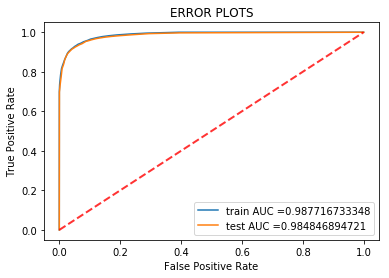

--------------------
Confusion Matrix :
[[5776  319]
 [ 450 5561]]
score :
0.940153761491
--------------------


In [349]:
# k nearest neighbor
knn = KNearestNeighbors()
# param_grid = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51, 61, 63]}
# best_knn = knn.get_best_knn_grid_search(X_train, y_train, param_grid)
best_knn = knn.get_best_knn_grid_search(X_train, y_train)

# roc_auc plot
accuracy = AccuracyMeasures()
accuracy.roc_curve_plot(X_train, X_test, y_train, y_test, best_knn)

# confusion matrix
accuracy.modified_confusion_matrix(X_train, X_test, y_train, y_test, best_knn)

Best Params         : {'max_depth': 15}
Best score          : 0.9896220319387904
Best estimator      : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
--------------------


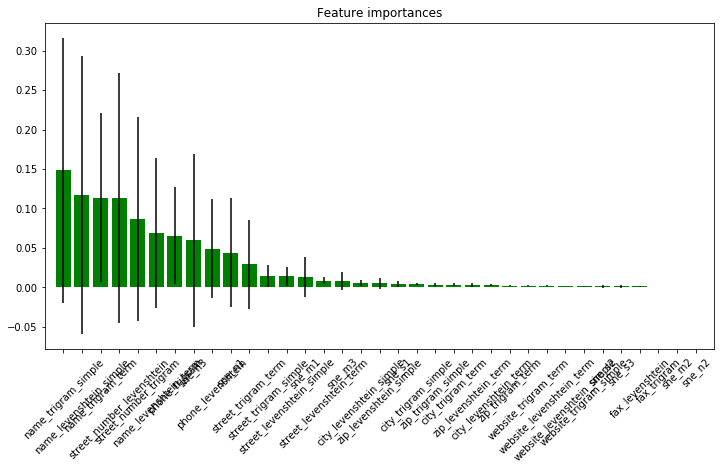

--------------------
name_trigram_simple - 0.148
name_levenshtein_simple - 0.117
name_trigram_term - 0.114
street_number_levenshtein - 0.113
street_number_trigram - 0.087
name_levenshtein_term - 0.069
phone_trigram - 0.066
sne_n3 - 0.060
phone_levenshtein - 0.049
sne_n1 - 0.044
street_trigram_term - 0.029
street_trigram_simple - 0.015
street_levenshtein_simple - 0.014
sne_m1 - 0.013
street_levenshtein_term - 0.008
sne_m3 - 0.008
city_levenshtein_simple - 0.006
zip_levenshtein_simple - 0.005
sne_s1 - 0.004
city_trigram_simple - 0.004
zip_trigram_simple - 0.003
city_trigram_term - 0.003
zip_levenshtein_term - 0.003
city_levenshtein_term - 0.003
zip_trigram_term - 0.002
website_trigram_term - 0.002
website_levenshtein_term - 0.002
website_levenshtein_simple - 0.002
website_trigram_simple - 0.001
sne_s2 - 0.001
sne_s3 - 0.001
fax_levenshtein - 0.001
fax_trigram - 0.001
sne_m2 - 0.001
sne_n2 - 0.000
--------------------


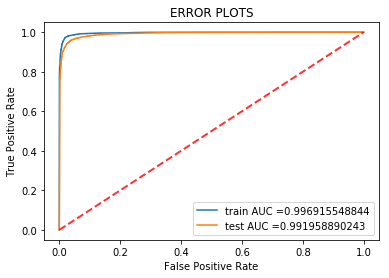

--------------------
Confusion Matrix :
[[5887  208]
 [ 278 5733]]
score :
0.961832929848
--------------------


In [351]:
# Random Forest Classifier 
forest = RandomForest()
param_grid = {'max_depth':[10, 15]}
best_forest = forest.get_best_forest_grid_search(X_train, y_train, param_grid)

# roc_auc plot
accuracy = AccuracyMeasures()
accuracy.roc_curve_plot(X_train, X_test, y_train, y_test, best_forest)

# confusion matrix
accuracy.modified_confusion_matrix(X_train, X_test, y_train, y_test, best_forest)

In [353]:
y_test = best_knn.predict(df_test2)

In [354]:
final_df = pd.DataFrame(data = { 'is_match': list(y_test)})

In [355]:
final_df = pd.concat([df_test_id.to_frame(), final_df], ignore_index=True, axis=1)

In [356]:
final_df.columns=['id', 'is_match']
final_df.to_csv('result.csv', index=False)